# Fourier analysis: a low pass filter with `nn.Modules`
We define an architecture in `PyTorch` which trains a  model of the form
$$y = b + \sum_{k=1}^na_k\cos(kx) + \sum_{k=1}^nb_k\sin(kx)$$
to learn data obtained by sampling the function
$$y = -1 + \cos(x) - 2\sin(2x) + .2\sin(20x)\,.$$

If $n < 20$ for example, then the model should (approximately) filter out the noisy component $.2\sin(20x)$.

According to the architecture, the `model` computes $\cos(ix)$ and $\sin(ix)$ for $i=1, \dots, n$, and combines them with a `nn.Linear`.  Thus, $b$ corresponds to the bias and the coefficients $a_i, b_i$, $i=1, \dots, n$ correspond to the weights in this `nn.Linear`.

---
tags: pytorch, tutorial, Fourier analysis

# Imports

In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

# Data
Create a function such as
$$y = 3\cos(x) - \sin(x)\,.$$

In [2]:
inputs = torch.linspace(-3., 3., 101).view(-1, 1)
targets = -1. + 1.*torch.cos(inputs)  - 2.*torch.sin(2*inputs) + .2*torch.cos(20*inputs)

# Architecture

In [3]:
class Filter(nn.Module):
    def __init__(self, n=1):
        super(Filter, self).__init__()
        self.n = n
        self.linear = nn.Linear(2*self.n, 1)
        
    def forward(self, x):
        ycos = [torch.cos(i*x) for i in range(1, self.n+1)]
        ysin = [torch.sin(i*x) for i in range(1, self.n+1)]
        y = torch.stack(ycos + ysin, dim=1).reshape(-1, 2*self.n)
        y = self.linear(y)
        return y

# Initialize model, optimizer, etc.

In [4]:
model = Filter(n=2)

criterion = nn.MSELoss(reduction='mean')

lr = .01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## Visualization at initialization

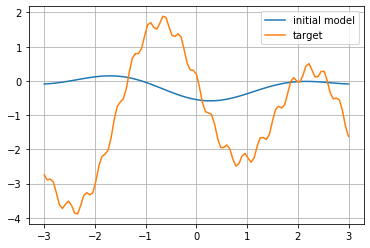

In [5]:
with torch.no_grad():
    outputs = model(inputs)

plt.plot(inputs, outputs, label='initial model')
plt.plot(inputs, targets, label='target')
plt.legend();
plt.grid();

# Training

100%|██████████| 750/750 [00:00<00:00, 3490.87it/s]


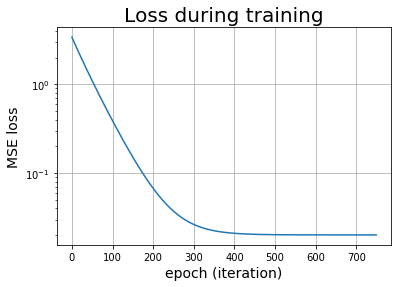

In [6]:
losses = []

n_epochs = 750

for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    losses.append(loss.data.item())
plt.plot(losses);
plt.yscale('log')
plt.grid();
plt.title("Loss during training", fontsize=(20));
plt.xlabel("epoch (iteration)", fontsize=14)
plt.ylabel("MSE loss", fontsize=14);    

## Visualization after training

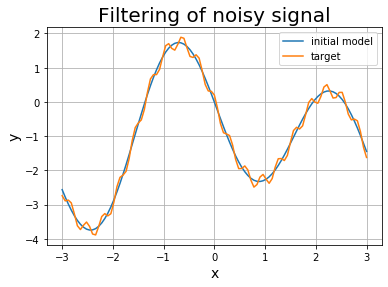

In [7]:
with torch.no_grad():
    outputs = model(inputs)

plt.plot(inputs, outputs, label='initial model')
plt.plot(inputs, targets, label='target')
plt.legend();
plt.grid();
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Filtering of noisy signal", fontsize=20);

# Coefficients of approximation
Inspect the weights and bias of `model`'s `linear` attribute:

In [8]:
print(f"Model bias:       {model.linear.bias.data.item():.4f}")
print(f"Model weights:    ", end="")
print(" ".join([f"{item:.4f}" for item in list(model.linear.weight.data.flatten().numpy())]))

Model bias:       -1.0031
Model weights:    1.0054 -0.0060 -0.0001 -1.9992


We nearly recover the desired coefficients.